# Apache Kafka for Real-time Reinforcement Learning
## ST446 Distributed Computing for Big Data
### Student 10173

This notebook contains the technical aspect of the project (cluster setup, screenshots, results, etc). I recommend to first read the project report, then this notebook, and finally the python files.

## 1. Compute the Baseline

First, I compute the baseline result, which is simply the average observed reward in the dataset. I use a subset of 10,000 rows of the Yahoo Front Page Click Log Dataset ([link](https://webscope.sandbox.yahoo.com/catalog.php?datatype=r&did=49)).

In [8]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

from IPython.display import Image

In [2]:
# read the data
yahoo_df = pd.read_csv('users_large.csv')
print(yahoo_df.shape)
yahoo_df.head()

(10000, 9)


,timestamp,displayed_article_id,user_click,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6
0,1241160900,109513,0,1,0.000012,0.000000,0.000006,0.000023,0.999958
1,1241160900,109484,0,1,0.088932,0.003915,0.592269,0.314084,0.000801
2,1241160900,109495,0,1,0.000293,0.000002,0.000411,0.000770,0.998524
3,1241160900,109494,0,1,0.011889,0.863387,0.000385,0.124338,0.000001
4,1241160900,109492,0,1,0.000054,0.000002,0.000022,0.000087,0.999835


### 2.1 Simple Baseline

In [4]:
baseline = yahoo_df.user_click.mean()
print('Observed Average Reward', baseline)
# print('with standard deviation', yahoo_df.user_click.var()**0.5)

Observed Average Reward 0.031


This is my baseline result. Note that the data was collected by randomly choosing articles for users. Of course, the goal is to improve upon this baseline.

## 2. Compute the Ground Truth Click Probabilities 

I also compute the average reward per arm, which I use in order to simulate an online learning scenario as described in the project report.

In [5]:
per_arm = yahoo_df.groupby('displayed_article_id').user_click.mean()
pd.DataFrame(per_arm)

,user_click
displayed_article_id,
109453,0.026749
109473,0.036190
109484,0.026477
109492,0.018450
109494,0.045267
109495,0.021654
109498,0.013780
109501,0.024590
109502,0.039761


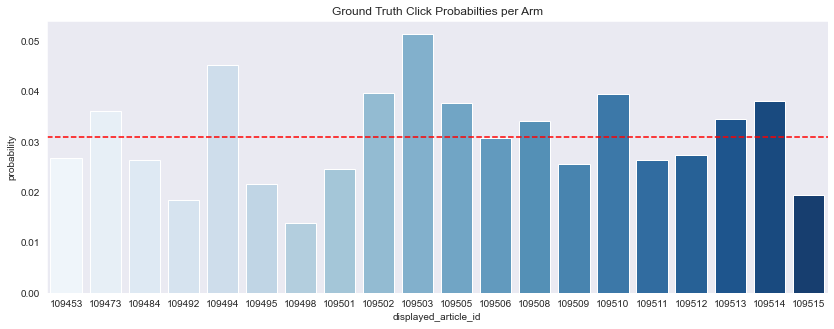

In [14]:
fig, ax = plt.subplots(figsize=(14,5))
sns.barplot(x=per_arm.index, y=per_arm.values, palette='Blues')
ax.axhline(0.031, ls='--', color='r')
plt.title('Ground Truth Click Probabilties per Arm')
plt.ylabel('probability')
plt.savefig('images/ground_truth.jpg')

These are the ground truth click probabilities, which range from just above 1 percent (the worst arm has index 6) to around 5 percent (best arm has index 9).

## 3. Cluster Setup

I first create a bucket and initialize a Dataproc cluster with the following setup.
```shell
# create bucket
gsutil mb -l europe-west2 -p st446-lse-2021 gs://mybucket446

# start cluster
gcloud beta dataproc clusters create project-cluster \
	--enable-component-gateway \
	--project st446-lse-2021 --bucket mybucket446 \
    --image-version=1.4-debian10 \
    --region=europe-west2 --zone europe-west2-a --single-node \
	--master-machine-type n1-standard-4 --master-boot-disk-size 500 \
    --optional-components=ANACONDA,JUPYTER,ZOOKEEPER \
    --metadata='CONDA_PACKAGES=scipy tensorflow' \
    --metadata='PIP_PACKAGES=confluent-kafka tensorflow-io' \
    --initialization-actions=\
        gs://goog-dataproc-initialization-actions-europe-west2/python/conda-install.sh,\
        gs://goog-dataproc-initialization-actions-europe-west2/python/pip-install.sh,\
        gs://goog-dataproc-initialization-actions-europe-west2/kafka/kafka.sh
```

Once the cluster is up, I run the following commands to start Kafka, initialize the necessary "topics" (= Kafka streams), and run a console consumer, which is simply for the sake of monitoring. I use a replication factor of one and a single partition.

```shell
# run kafka in tab 0
cd /usr/lib/kafka
sudo -s
bin/kafka-server-start.sh config/server.properties &

# create topics in tab 1
kafka-topics.sh --create --zookeeper localhost:2181 --replication-factor 1 --partitions 1 --topic training
kafka-topics.sh --create --zookeeper localhost:2181 --replication-factor 1 --partitions 1 --topic policy

# run kafka console consumer in tab 1
cd /usr/lib/kafka
bin/kafka-console-consumer.sh --bootstrap-server localhost:9092 --topic training --from-beginning
```

I also upload the python files application.py and online_learner.py to the virtual machine.

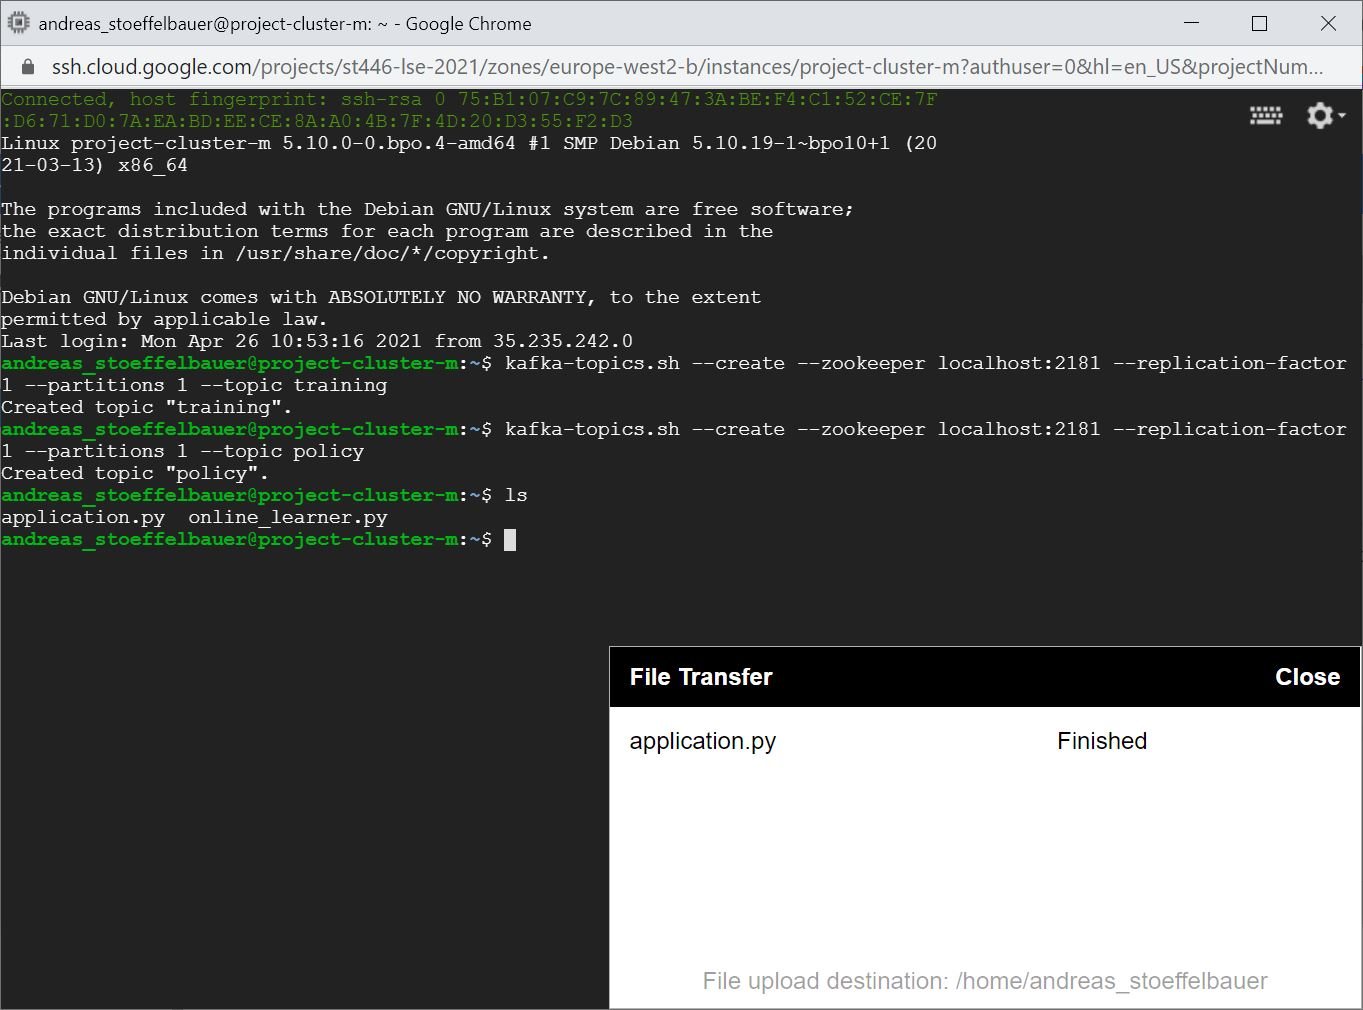

In [2]:
from IPython.display import Image
Image(filename='images/upload_py.JPG') 

## 4. Run the Online Learner and the Application

After uploading the files *online_learner.py* and *application.py* to the virtual machine, I start the online learner which begins to push parameters to the stream "policy" while also waiting for training data to arrive in order to update the parameters.

```shell
# start the online learner
python online_learner.py
```

I then start the application. Ad described in the project report, I simulate a scenario where multiple applications run at the same time by using a while loop.


```shell
# start the appliaction
python application.py
```

The experiment runs for ~30 seconds, which is the time it takes for approximately 10,000 timesteps to complete.

#### Terminal Output of the Application
The application simulates a real scenario in which an article is shown to a user and a reward is observed. The tuple $(a,r)$ is then pushed to the Kafka topic "rl-stream". Note that in the beginning, arm #0 is chosen most of the time.

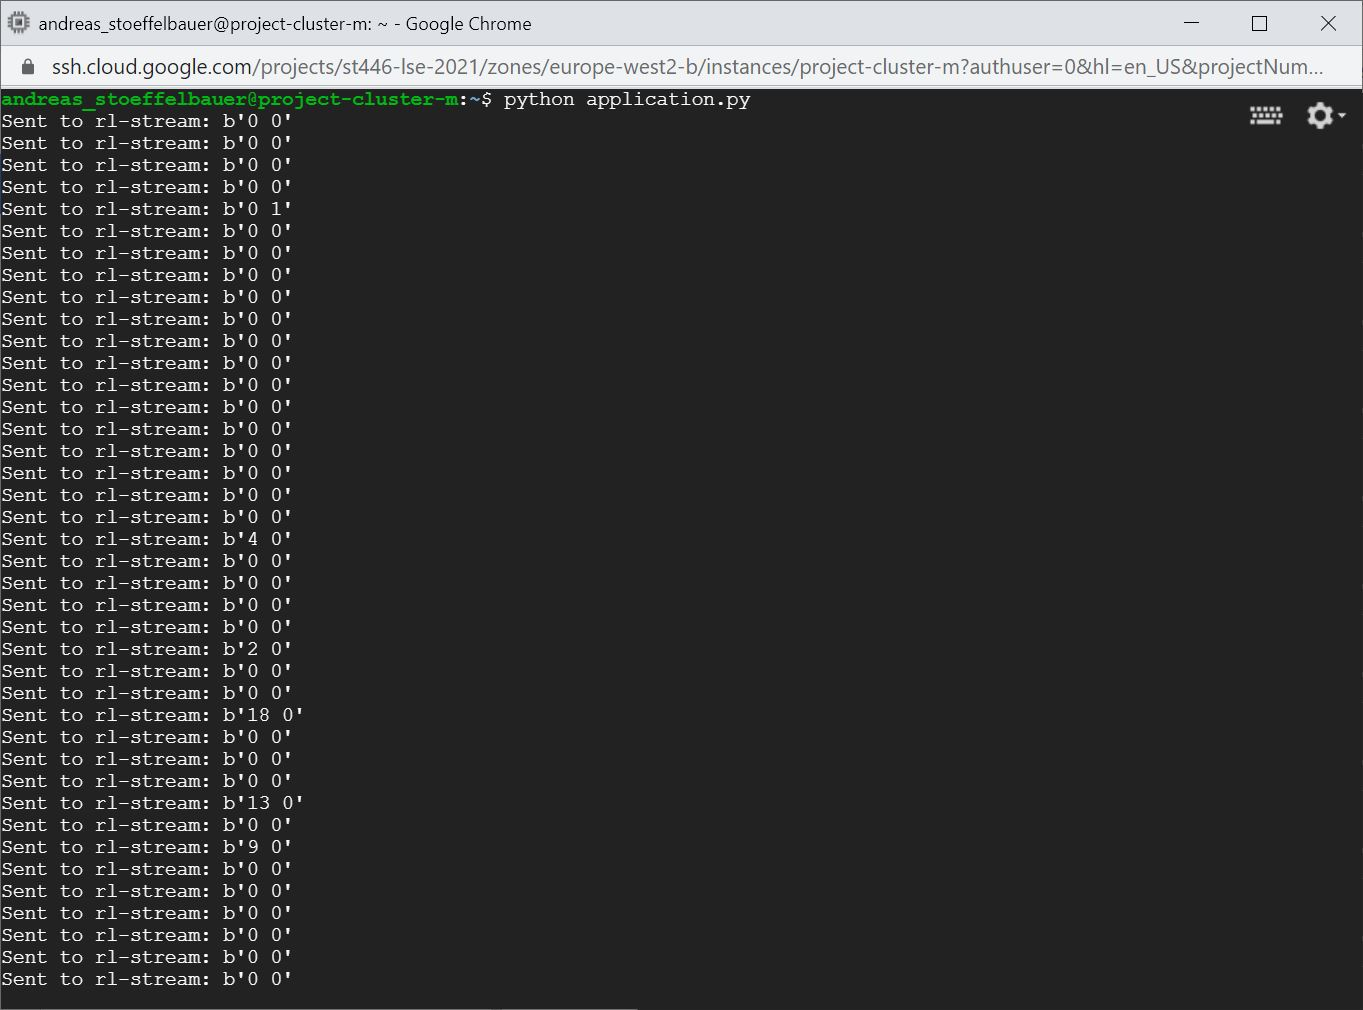

In [4]:
Image(filename='images/run_app.JPG') 

#### Terminal Output of the Online Learner

The online learner pulls the training data from the topic "rl-stream", updates the policy parameters, and pushes them to the topic "policy". Below is a screenshot of terminal output of the online learner from the very beginning (when it receives the first few training observations).

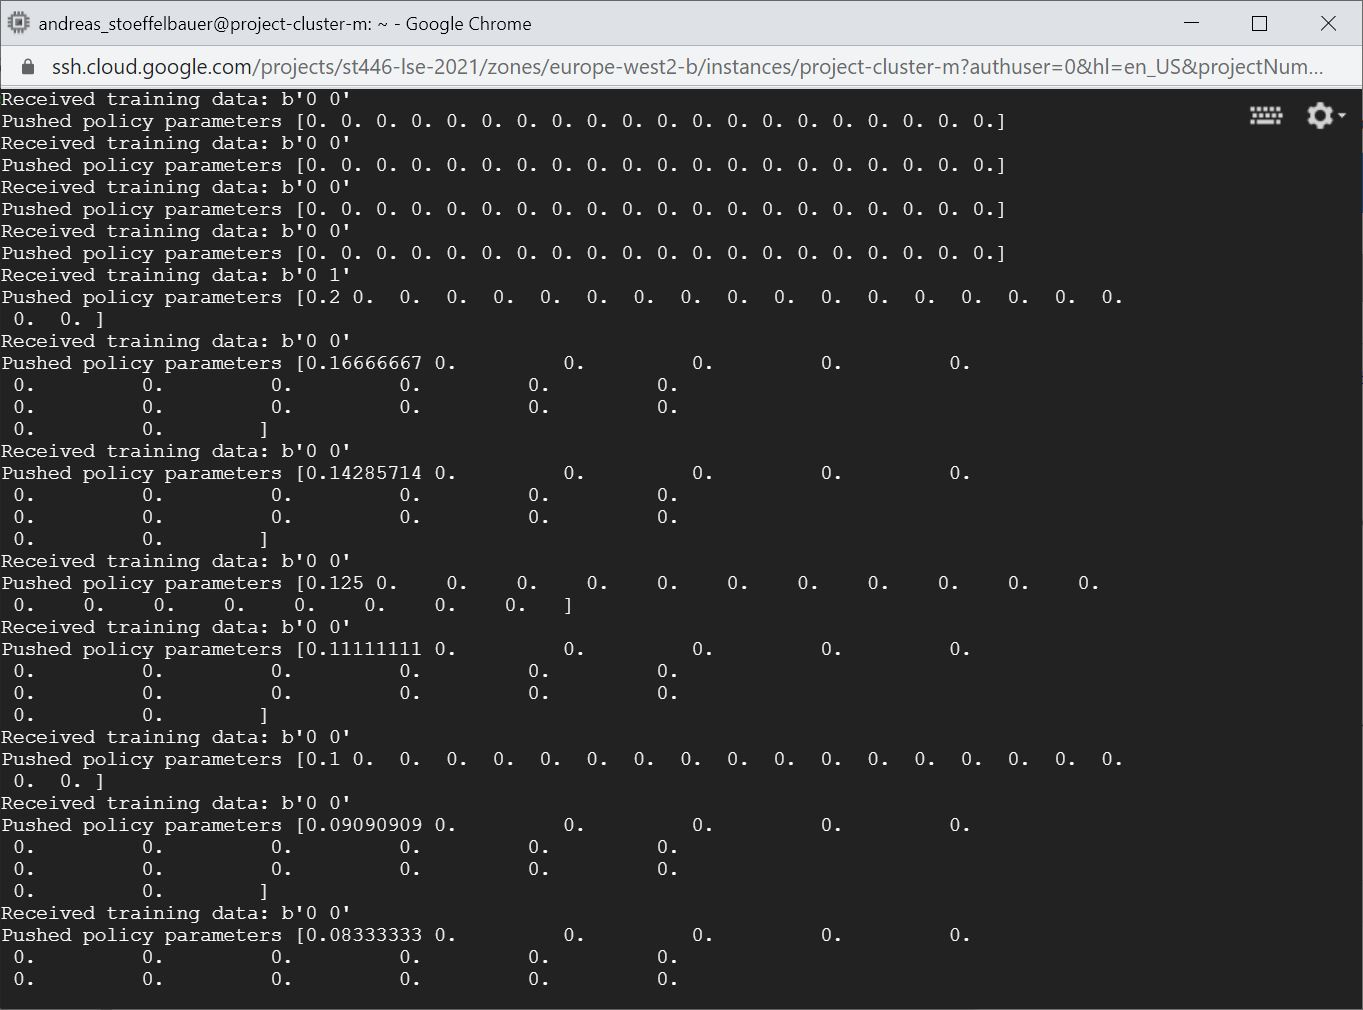

In [1]:
from IPython.display import Image
Image(filename='images/run_learner_begin.JPG') 

The screenshot below shows the terminal output after the online learner has received many more training observations (most likely a few thousand). The average rewards are already closer to the ground truth click probabilities and arm #9 has correctly been identified as the best arm, which is therefore chosen most often.

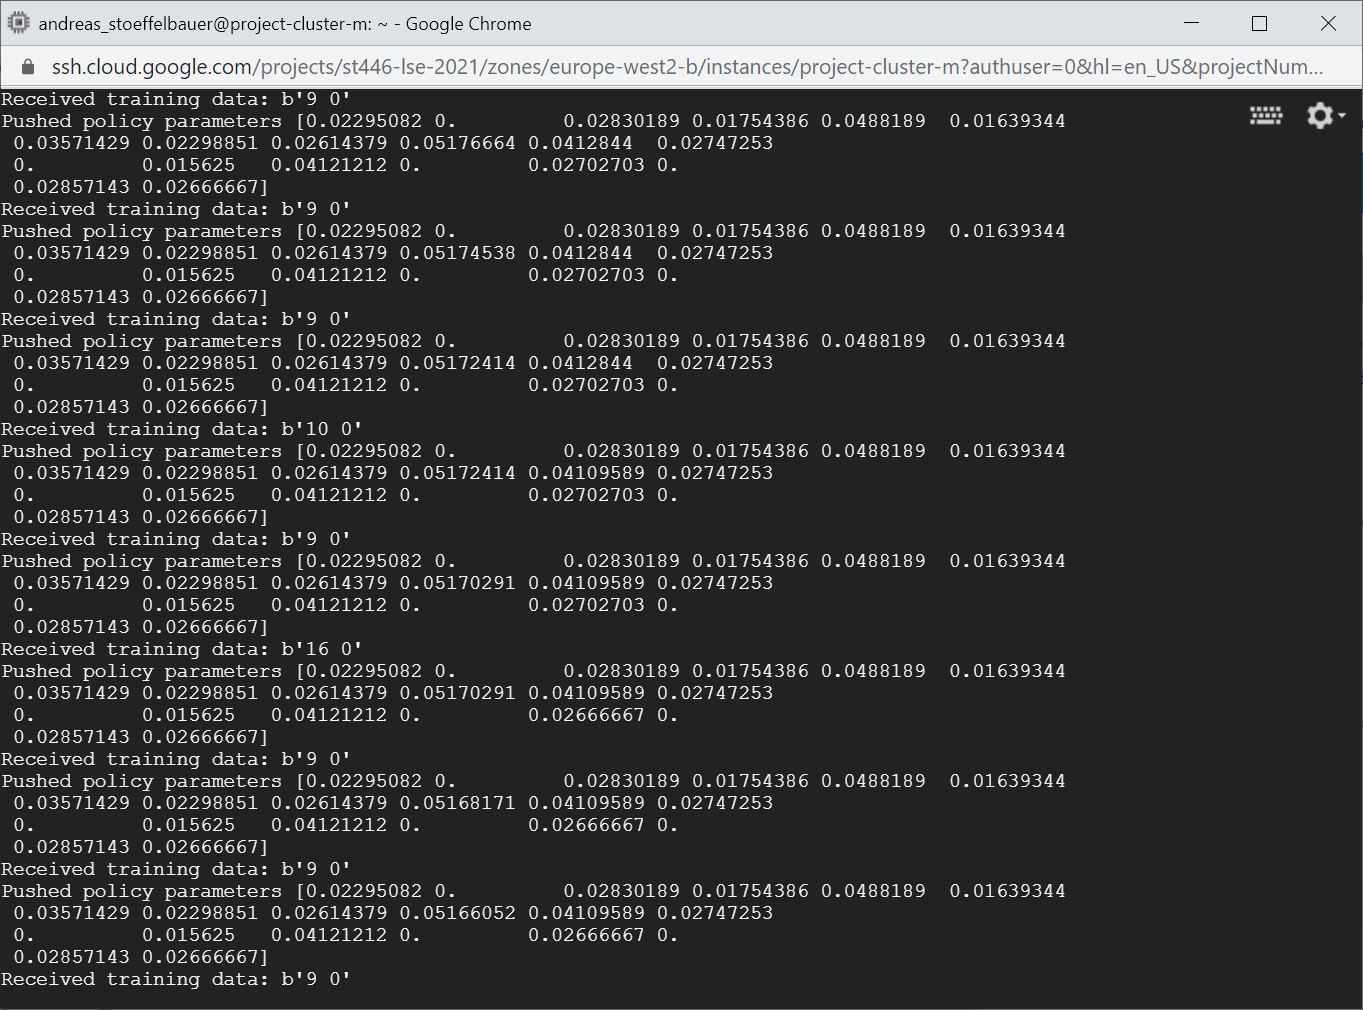

In [2]:
from IPython.display import Image
Image(filename='images/run_learner_later.JPG') 

## 3. Results

### 3.1 Collect all Observed Rewards from Kafka

Since all the data involved is streamed via Kafka and these streams are persistent by default, we can simple read a stream from the beginning in order to perform an analysis. For example, "rl-stream" is simply a history of all $(a,r)$ tuples that were collected, which is exactly what we need for analyzing the performance of the bandit.

In [2]:
history = []

In [3]:
from confluent_kafka import Consumer, Producer, KafkaError

settings = {
    'bootstrap.servers': 'localhost:9092',
    'group.id': 'mygroup',
    'client.id': 'client-1',
    'enable.auto.commit': True,
    'session.timeout.ms': 6000,
    'default.topic.config': {'auto.offset.reset': 'smallest'}
}

c = Consumer(settings)

c.subscribe(['training'])

try:
    while True:
        msg = c.poll(0.2)
        if msg is None:
            continue
        elif not msg.error():
            # print('Received message: {0}'.format(msg.value()))
            history.append(msg.value())
        elif msg.error().code() == KafkaError._PARTITION_EOF:
            print('End of partition reached {0}/{1}'
                  .format(msg.topic(), msg.partition()))
            break #?
        else:
            print('Error occured: {0}'.format(msg.error().str()))

except KeyboardInterrupt:
    pass

finally:
    c.close()

In [4]:
# show last ten observed training tuples
# arm #9 was indeed chosen most often
history[-10:]

[b'9 0',
 b'9 0',
 b'9 0',
 b'9 0',
 b'9 0',
 b'9 0',
 b'9 0',
 b'9 0',
 b'9 0',
 b'3 0']

In [5]:
# decode the rewards
rewards = [float(element.decode('ascii').split()[1]) for element in history]
rewards = np.array(rewards)
rewards[:10]
# first 10 are 0 (no clicks observed, they are rare)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# compute cumulative average
cum_average_reward = np.cumsum(rewards)/np.arange(1,len(rewards)+1)

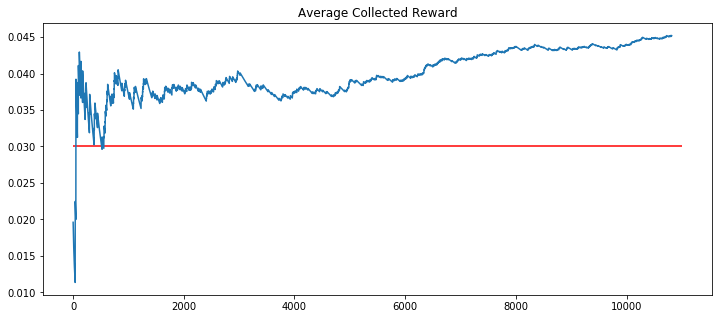

In [12]:
plt.subplots(figsize=(12, 5))
plt.plot(cum_average_reward[50:])
plt.hlines(0.03, 0, 11000, colors='r');
plt.title('Average Collected Reward')
plt.savefig('reward.jpg')

The graphic shows that the agent indeed learns and outperforms the baseline (see project report for a more detailed analysis of the plot).

### 3.2 Collect a History of the Policy Parameters

We can also get a history of the policy parameters by reading the stream "policy". To emphasize an important point again: the "parameters" here is simply the vector of average rewards per arm.

In [8]:
policy_history = []

In [9]:
c = Consumer(settings)

c.subscribe(['policy'])

try:
    while True:
        msg = c.poll(0.2)
        if msg is None:
            continue
        elif not msg.error():
            # print('Received message: {0}'.format(msg.value()))
            policy_history.append(msg.value())
        elif msg.error().code() == KafkaError._PARTITION_EOF:
            print('End of partition reached {0}/{1}'
                  .format(msg.topic(), msg.partition()))
            break #?
        else:
            print('Error occured: {0}'.format(msg.error().str()))

except KeyboardInterrupt:
    pass

finally:
    c.close()

In [10]:
policy_hist_list = [np.frombuffer(element) for element in policy_history]
policy_hist_matrix = np.stack(policy_hist_list, axis=0)
policy_hist_matrix.shape

(11323, 20)

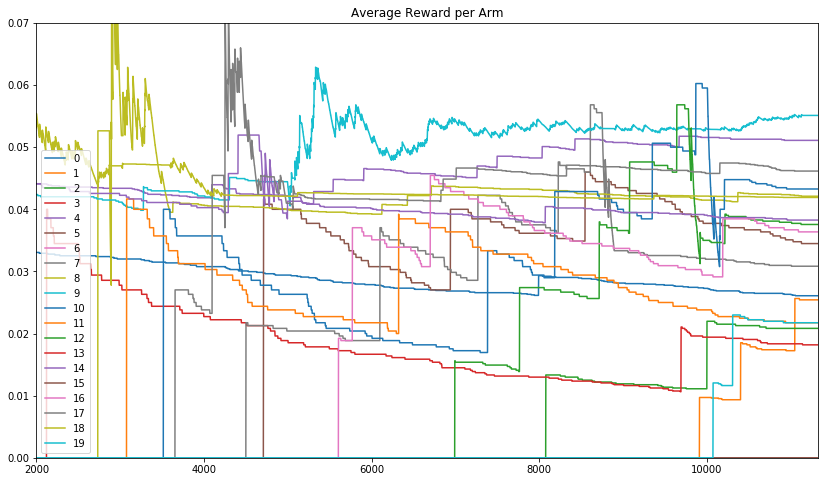

In [11]:
df = pd.DataFrame(policy_hist_matrix)
df[2000:].plot(ylim=(0, 0.07), figsize=(14,8));
plt.title('Average Reward per Arm')
plt.savefig('reward_arm.jpg')

As we can see arm #9 has the highest average reward (after a few thousand timesteps), and this aligns with the ground truth click probabilities.

### 3.3 A Non-Stationary Problem

In order to simulate a sudden concept drift, after 8,000 timesteps, the click probabilities for all arms suddently fall by a factor of 5 and one arm (arm #14) receives a click probability of 0.15, which is quite high.

Importantly, for the non-stationary scenario, I run *application_non_stationary.py* and *online_learner_non_stationary.py*.

```shell
# start the online learner
python online_learner_non_stationary.py

# start the application
python application_non_stationary.py
```

Again, I run the experiment for approximately 30 seconds.

In [56]:
history = []

In [57]:
c = Consumer(settings)

c.subscribe(['training'])

try:
    while True:
        msg = c.poll(0.2)
        if msg is None:
            continue
        elif not msg.error():
            # print('Received message: {0}'.format(msg.value()))
            history.append(msg.value())
        elif msg.error().code() == KafkaError._PARTITION_EOF:
            print('End of partition reached {0}/{1}'
                  .format(msg.topic(), msg.partition()))
            break #?
        else:
            print('Error occured: {0}'.format(msg.error().str()))

except KeyboardInterrupt:
    pass

finally:
    c.close()

In [58]:
# show sample from history
history[-10:]

[b'5 1',
 b'5 0',
 b'5 0',
 b'5 0',
 b'5 0',
 b'5 0',
 b'12 0',
 b'5 0',
 b'5 0',
 b'5 0']

In [59]:
# decode the rewards
rewards = [float(element.decode('ascii').split()[1]) for element in history]
rewards = np.array(rewards)
rewards[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [90]:
# compute cumulative average
cum_average_reward = np.cumsum(rewards)/np.arange(1,len(rewards)+1)
cum_average_reward[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

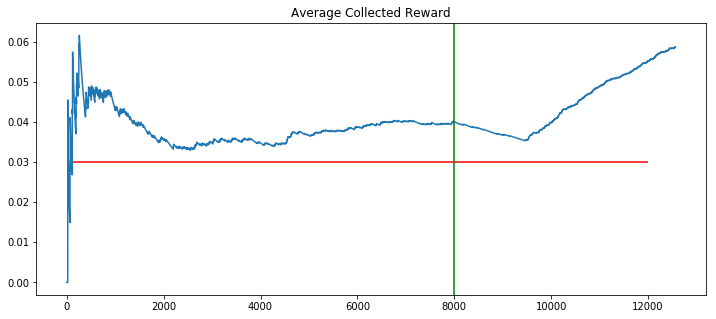

In [91]:
plt.subplots(figsize=(12, 5))
plt.plot(cum_average_reward)
plt.hlines(0.03, 0, 12000, colors='r')
plt.axvline(x=8000, color='g')
plt.title('Average Collected Reward')
plt.savefig('reward2.jpg')

After 8,000 timesteps, the average reward starts to fall. Once the online learner has realized that there is a new best arm, however, it begins to rise again.

In [92]:
# moving average
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

mov_average = moving_average(rewards, 1200)

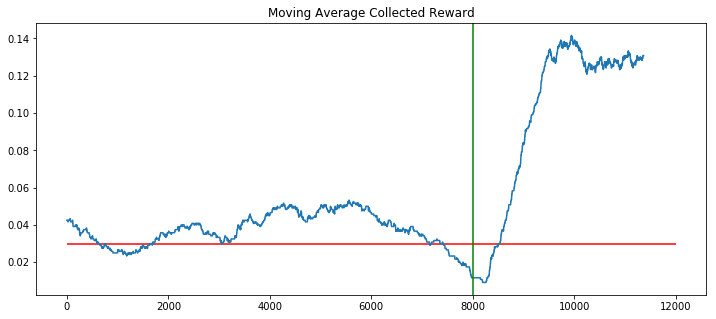

In [93]:
plt.subplots(figsize=(12, 5))
plt.plot(mov_average)
plt.hlines(0.03, 0, 12000, colors='r')
plt.axvline(x=8000, color='g')
plt.title('Moving Average Collected Reward')
plt.savefig('mov_average_reward.jpg')

This plot is a "windowed" average of the rewards over the previous 1,200 timesteps. Generally speaking, such an average is better for tracking/visualizing concept drift than a running global average. However, with very small click probabilities, a quite large window must be chosen.